In [1]:
import pandas as pd
import glob
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#paths + settings
results_path = "/data/workspaces/lag/workspaces/lg-ukbiobank/projects/rest-multimodal/results/"
in_path_sets = "/data/clusterfs/lag/users/jitame/SENT_CORE/geno/regenie/exome/functional_annotation/selected_variants_v1"
run_name = "AICHA_rs_conn"
set_size=200 #DON'T CHANGE, was used to run regenie in smaller sets on RAP
save_lists=False

alpha_suggestive = -np.log10(0.05/18882)    
alpha_burden_genebass = -np.log10(6.7 * 10 ** -7)
alpha_skato_genebass = -np.log10(2.5 * 10 ** -7) #from genebass paper: https://www.cell.com/cell-genomics/fulltext/S2666-979X(22)00110-0#secsectitle0080
      

In [3]:
#! pyensembl install --release 108 --species homo_sapiens

In [3]:
def split_sets(in_path, file_name_ext, run_name, set_size, chr_no, save_lists=True):
    """
    Subdivides all genes for one chromosome into smaller sets in order to improve parallellization
    """
    
    #load data
    all_sets = pd.read_csv(os.path.join(in_path, file_name_ext), sep="\t", names="Gene CHR POS VARS".split())
    
    #get number of sets
    no_sets = ( len(all_sets) // set_size ) + 1

    if save_lists:
        for i in range( no_sets ):      
            #get set 
            this_set = list(all_sets.Gene[ (i*set_size):((i+1)*set_size)])
            print(this_set[0])

            #save set
            with open(os.path.join(in_path, "{0}_c{1}_extract_set_{2}.txt".format(run_name, chr_no, i, no_sets)), 'w') as file:
                for row in this_set:
                    s = "".join(map(str, row))
                    file.write(s+'\n')

    return chr_no, no_sets

df_all_sets = pd.DataFrame(columns="Chr_no No_sets".split())

for c in range(1, 23, 1):
    df_all_sets.loc[len(df_all_sets)] = split_sets(in_path = in_path_sets,
                                                       file_name_ext = "{0}_c{1}_set_list.txt".format(run_name, c) ,
                                                       run_name = run_name,
                                                       set_size = set_size,
                                                       chr_no = c,
                                                       save_lists=save_lists)
c="X"
df_all_sets.loc[len(df_all_sets)] = split_sets(in_path = in_path_sets,
                                                       file_name_ext = "{0}_c{1}_set_list.txt".format(run_name, c) ,
                                                       run_name = run_name,
                                                       set_size = set_size,
                                                       chr_no = c,
                                                       save_lists=save_lists)

In [4]:
## FUNCTIONS

## DATA LOADING FUNCTIONS
# (1) read file
# (2) add together all phenos per set as extra columns
# (3) add all sets per chromosome
# (4) add all chromosomes

def read_sumstats_REGENIE(fn):
    """
    Reads sumstats
    
    Converts regenie output to MRP format (PLINK-like)
    - add necessary column
    - change column names
    
    """
    data = pd.read_csv(fn, sep=" ", skiprows=1)
    
    #get phenotype name
    pheno_in = re.search("sent_edges_*.*", fn)
    pheno = pheno_in.group()[:-11]
    
    data["TEST_ID"] = data["ID"] + "." + data["TEST"]
    
    #rename
    data.rename(columns = {"LOG10P": "LOGP_{0}".format(pheno),
                           "BETA":"BETA_{0}".format(pheno),
                           "CHISQ":"CHISQ_{0}".format(pheno),
                           "SE":"SE_{0}".format(pheno)},
                inplace=True)
    
    return data.set_index("TEST_ID")
    #return data

def data_loader_REGENIE_set(regenie_path, search_term):
    """
    loads data for all phenotypes of one set
    """
    #get file list
    file_list = sorted(glob.glob(os.path.join(regenie_path, search_term)))
    
    print(search_term + " --> number of files: " + str(len(file_list)))
          
    if len(file_list) > 0:
        #load data (cleaning up in helper functions)
        return pd.concat(map(read_sumstats_REGENIE, file_list), join="inner", axis=1)
    
    else:
        return pd.DataFrame()
    
def data_loader_REGENIE_chromosome(regenie_path, search_term, no_sets):
    """
    loads data for all sets and phenotype of a particular chromosome
    """
    return pd.concat(map(data_loader_REGENIE_set, [regenie_path]*no_sets, [search_term.format(i) for i in range(no_sets)]), axis=0)

def data_loader_REGENIE_all_chromosomes(regenie_path, search_term, no_sets, chr_nos):
    """
    """
    regenie_paths=[regenie_path.format(chr_no) for chr_no in chr_nos]
    search_terms=[search_term.format(chr_no, "{}") for chr_no in chr_nos]
    
    return pd.concat(map(data_loader_REGENIE_chromosome, regenie_paths, search_terms, no_sets))


## HELPERS ##


def load_column_names(fn):
    return [str(x) for x in open( fn ).read().split('\n')[:-1] ]

def get_gene_name(gene_id, data_ens):
    """
    """
    try:
        gene_name = data_ens.gene_name_of_gene_id(gene_id)
    except ValueError:
        gene_name = ""
    return gene_name

def add_gene_names(data):
    """
    ADDS GENE NAME BASED ON ENSEMBL ID
    """
    
    from pyensembl import EnsemblRelease
    data_ens = EnsemblRelease(108)
    
    #parse gene ids and names
    data["gene_id"] = [id_name.split(".")[0] for id_name in data["ID"]]
    data["gene_name"] = [get_gene_name(gene_id, data_ens) for gene_id in data["gene_id"]]
    
    return data

def get_min_P_REGENIE(data, pheno_list=None):
    """
    Finds highest -logp value per variant
    
    Returns data with MIN_LOGP column added.
    
    """
    #filter
    if pheno_list is None:
        r=re.compile("LOGP_*.")
        pheno_list = list(filter(r.match, data.columns))
    
    #find highest
    return data[pheno_list].T.max()

## ALL DATA MUNGING
    
def data_munging_all(regenie_path, search_term, no_sets, chr_nos, fn_pheno_edges, fn_pheno_HDs):
    """
    """
    
    data = data_loader_REGENIE_all_chromosomes(regenie_path, search_term, no_sets, chr_nos)
    
    data = data.T.drop_duplicates().T
    
    phenos_edges = ["LOGP_sent_edges_"+x for x in load_column_names(fn_pheno_edges)]
    phenos_HDs = ["LOGP_sent_edges_"+x for x in load_column_names(fn_pheno_HDs)]
    
    data["MINP_edges"] = get_min_P_REGENIE(data, phenos_edges)
    data["MINP_HDs"] = get_min_P_REGENIE(data, phenos_HDs)
    
    data = add_gene_names(data)
    
    return data

def get_cumulative_pos(df):
    """
    Adds cumulative position to dataframe for plotting purposes
    """
    running_pos = 0

    cumulative_pos = []

    for chrom, group_df in df.groupby('CHROM'):  
        cumulative_pos.append(group_df['GENPOS'] + running_pos)
        running_pos += group_df['GENPOS'].max()

    df['cumulative_pos'] = pd.concat(cumulative_pos)
    
    return df

def miami_exome_regenie(df1, df2, y_name1, y_name2, y_dsc1, y_dsc2, title_str, alpha, figargs= {"figsize":(14,10),"dpi":150}):
    """
    Big plotting function to make a gene-based Miami plot
    """
    
    no_genes = len(df1)
    
    df1 = get_cumulative_pos(df1)
    df2 = get_cumulative_pos(df2)
    
    max_p1 = np.max(df1[y_name1])
    max_p2 = np.max(df2[y_name2])
    
    max_p = np.max([max_p1, max_p2]) 
    
    fig, (ax1, ax2) = plt.subplots(2, 1, 
        gridspec_kw={'height_ratios': [1, 1]},**figargs)
    plt.subplots_adjust(hspace=0.16)
    
    g = sns.scatterplot(data=df1,
                        #x=df1.index.values,
                        x="cumulative_pos",
                        y=y_name1,
                        hue = 'CHROM',
                        palette = ['silver', 'darkslateblue'] * 12,
                        legend=None,
                        style=None,
                        s=6,
                        linewidth=0,
                        zorder=2,
                        ax=ax1,
                        edgecolor="black")     

    g = sns.scatterplot(data=df2,
                        #x=df2.index.values,
                        x="cumulative_pos",
                        y=y_name2,
                        hue = 'CHROM',
                        palette = ['silver', 'darkslateblue'] * 12,
                        legend=None,
                        style=None,
                        s=6,
                        linewidth=0,
                        zorder=2,
                        ax=ax2,
                        edgecolor="black") 
    
    ax1.set_xticks(df1.groupby('CHROM')['cumulative_pos'].median())
    ax1.set_xticklabels(df1['CHROM'].unique())
    ax1.set_xlabel('Chromosome')
    ax1.set_ylabel(y_dsc1)
    ax1.set_ylim([0, max_p])

    if alpha is not None:
        ax1.plot([np.min(df1["cumulative_pos"]), np.max(df1["cumulative_pos"])], [alpha, alpha], "--", color="dimgrey")
    
    ax2.set_xticks(df2.groupby('CHROM')['cumulative_pos'].median())
    ax2.set_ylim([0, max_p])
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xlabel('')
    ax2.set_xticklabels([])
    
    ax2.xaxis.set_ticks_position("top")
    ax2.set_ylabel(y_dsc2)
    
    if alpha is not None:
        ax2.plot([np.min(df2["cumulative_pos"]), np.max(df2["cumulative_pos"])], [alpha, alpha], "--", color="dimgrey")
   
    ax2.invert_yaxis()
    
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["left"].set_visible(True)
    ax1.spines["bottom"].set_visible(True)
    
    ax2.spines["top"].set_visible(True)
    ax2.spines["right"].set_visible(False)
    ax2.spines["left"].set_visible(True)
    ax2.spines["bottom"].set_visible(False)
    
    if alpha is not None:
        for gene in df1[df1[y_name1] > alpha].index.values:
            ax1.text(df1.loc[gene, "cumulative_pos"]+1, df1.loc[gene, y_name1]+0.25, df1.loc[gene, "gene_name"], horizontalalignment='left', size='small', color='black') #, weight='semibold')
        for gene in df2[df2[y_name2] > alpha].index.values:
            ax2.text(df2.loc[gene, "cumulative_pos"]+1, df2.loc[gene, y_name2]+0.25, df2.loc[gene, "gene_name"], horizontalalignment='left', size='small', color='black') #, weight='semibold')
    
    fig.suptitle(title_str)



In [6]:
#data = data_munging_all(regenie_path="/data/clusterfs/lag/users/jitame/SENT_CORE/geno/regenie_gene_based/c{}",
#                        search_term="AICHA_rs_conn_gene_based_additive_sum_c{0}_set_{1}_sent_edges_*.regenie.gz",
#                        no_sets=list(df_all_sets.No_sets),
#                        chr_nos=list(df_all_sets.Chr_no),
#                        fn_pheno_edges="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt",
#                        fn_pheno_HDs="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt")
#data.to_csv(os.path.join("/data/clusterfs/lag/users/jitame/SENT_CORE/geno/regenie_gene_based/", "all_exome_results.csv"))

In [5]:
data = pd.read_csv(os.path.join("/data/clusterfs/lag/users/jitame/SENT_CORE/geno/regenie_gene_based/", "all_exome_results.csv"), engine="pyarrow")

In [6]:
data = add_gene_names(data)

/tmp/ipykernel_57255/687663859.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumulative_pos'] = pd.concat(cumulative_pos)
/tmp/ipykernel_57255/687663859.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumulative_pos'] = pd.concat(cumulative_pos)
/tmp/ipykernel_57255/687663859.py:176: UserWarning: The palette list has more values (24) than needed (23), which may not be intended.
  g = sns.scatterplot(data=df1,
/tmp/ipykernel_57255/687663859.py:190: UserWarning: The palette list has more

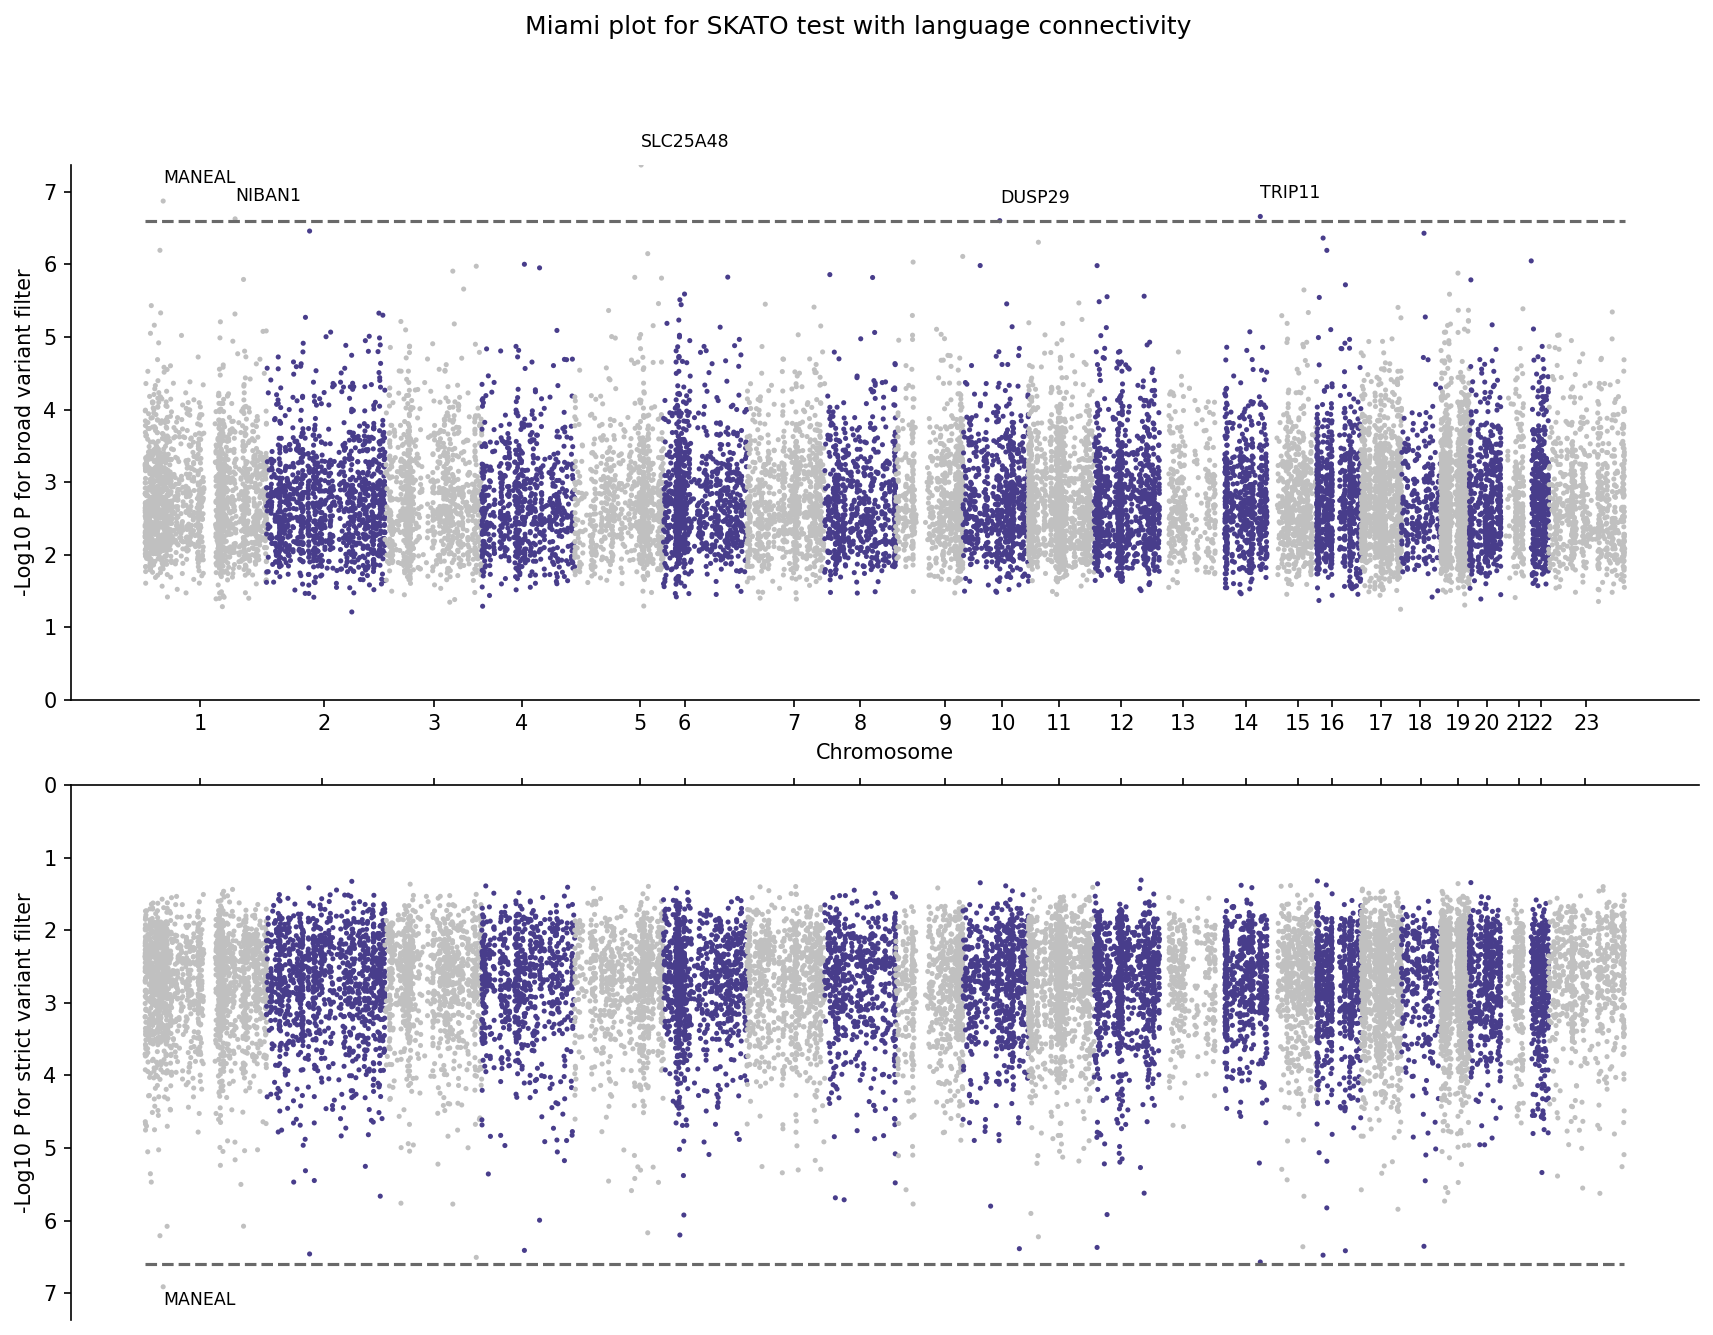

In [28]:
data_skato_strict = data[np.array([data["TEST"] == "ADD-SKATO", data["ALLELE1"] == "Strict.0.01"]).all(0).reshape((len(data), 1))]
data_skato_broad = data[np.array([data["TEST"] == "ADD-SKATO", data["ALLELE1"] == "Broad.0.01"]).all(0).reshape((len(data), 1))]
miami_exome_regenie(df1 = data_skato_broad,
                    df2 = data_skato_strict,
                    y_name1 = "MINP_edges",
                    y_name2 = "MINP_edges",
                    alpha = alpha_skato_genebass,
                    y_dsc1 = "-Log10 P for broad variant filter",
                    y_dsc2 = "-Log10 P for strict variant filter",
                    title_str = "Miami plot for SKATO test with language connectivity")
plt.savefig(os.path.join(results_path, "Figs", "SKATO_lang_conn.png"))
plt.savefig(os.path.join(results_path, "Figs", "SKATO_lang_conn.svg"))

/tmp/ipykernel_57255/687663859.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumulative_pos'] = pd.concat(cumulative_pos)
/tmp/ipykernel_57255/687663859.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumulative_pos'] = pd.concat(cumulative_pos)
/tmp/ipykernel_57255/687663859.py:176: UserWarning: The palette list has more values (24) than needed (23), which may not be intended.
  g = sns.scatterplot(data=df1,
/tmp/ipykernel_57255/687663859.py:190: UserWarning: The palette list has more

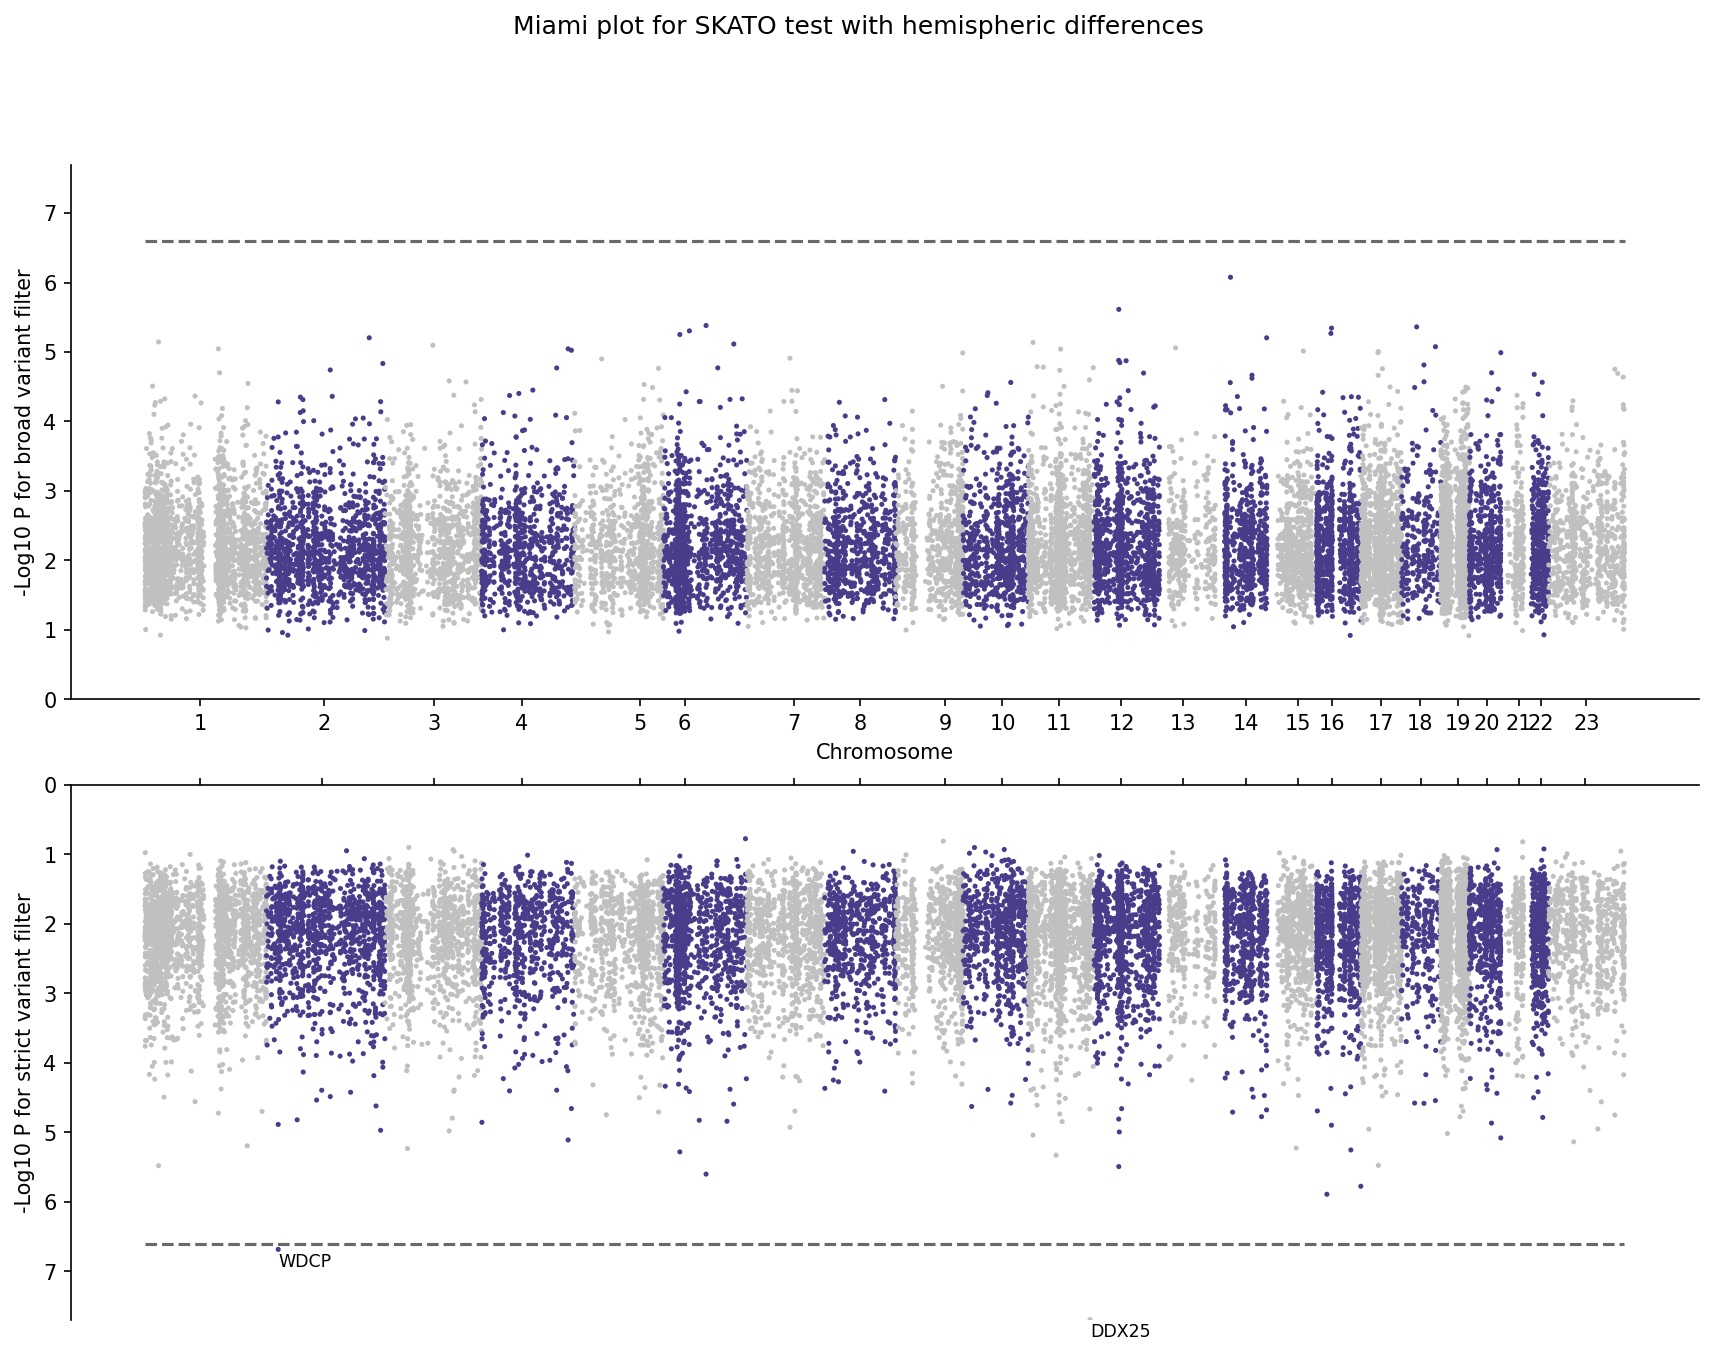

In [29]:
miami_exome_regenie(df1 = data_skato_broad,
                    df2 = data_skato_strict,
                    y_name1 = "MINP_HDs",
                    y_name2 = "MINP_HDs",
                    alpha = alpha_skato_genebass,
                    y_dsc1 = "-Log10 P for broad variant filter",
                    y_dsc2 = "-Log10 P for strict variant filter",
                    title_str = "Miami plot for SKATO test with hemispheric differences")
plt.savefig(os.path.join(results_path, "Figs", "SKATO_HDs.png"))
plt.savefig(os.path.join(results_path, "Figs", "SKATO_HDs.svg"))

In [ ]:
from qmplot import qqplot

import seaborn as sns


def make_ps_plot(df, minp_name, title_name, alpha, phenos, axs, i):
    data_minp = np.power(10, -df[minp_name].to_numpy())
    data_allp = np.power(10, -df[phenos].to_numpy()).flatten()
    sig_ps = df.loc[df[minp_name] > alpha, phenos]
    
        #QQ-plot of Min Ps
    #qqplot(data = data_minp,
    #       marker="o",
    #       #title="Lowest P-values " + title_name,
    #       xlabel=r"Expected $-log_{10}{(P)}$",
    #       ylabel=r"Observed $-log_{10}{(P)}$",
    #       ax=axs[i, 0])
    #axs[i,0].set_ylim(0, np.max(data_minp)+1)
        
        #QQ-plot of underlying Ps
    qqplot(data = data_allp,
           marker="o",
           #title="All P-values " + title_name,
           xlabel=r"Expected $-log_{10}{(P)}$",
           ylabel=r"Observed $-log_{10}{(P)}$",
           ax=axs[i, 0])
    #axs[i,1].set_ylim(0, np.max(data_allp)+1)
        
        ##KDE plot of Ps
    if len(sig_ps) > 0:
        sns.kdeplot(sig_ps.T, bw_method=0.25, ax=axs[i, 1])
        #axs[i,2].set_title("P-value distribution for significant genes for "+title_name)

def make_all_ps_figure(data_broad, data_strict, fn_pheno_edges, fn_pheno_HDs, alpha):
    
    #data management
    data_broad.set_index("gene_name", inplace=True)
    data_strict.set_index("gene_name", inplace=True)
    
    phenos_HDs = ["LOGP_sent_edges_"+x for x in load_column_names(fn_pheno_HDs)]
    phenos_edges = ["LOGP_sent_edges_"+x for x in load_column_names(fn_pheno_edges)]
    
    #plotting
    fig, axs = plt.subplots(4, 2,
                            figsize=(12, 16), gridspec_kw = { 'hspace' : 0.4, 'wspace' : 0.4 } )
    
    make_ps_plot(df = data_broad,
                 minp_name="MINP_edges",
                 title_name="language connectivity with broad filter" ,
                 alpha=alpha,
                 phenos=phenos_edges,
                 axs=axs,
                 i=0)
    make_ps_plot(df = data_strict,
                 minp_name="MINP_edges",
                 title_name="language connectivity with strict filter" ,
                 alpha=alpha,
                 phenos=phenos_edges,
                 axs=axs,
                 i=1)
    make_ps_plot(df = data_broad,
                 minp_name="MINP_HDs",
                 title_name="hemispheric differences with broad filter" ,
                 alpha=alpha,
                 phenos=phenos_HDs,
                 axs=axs,
                 i=2)
    make_ps_plot(df = data_strict,
                 minp_name="MINP_HDs",
                 title_name="hemispheric differences with strict filter" ,
                 alpha=alpha,
                 phenos=phenos_HDs,
                 axs=axs,
                 i=3)

In [ ]:
data_skato_strict = data[np.array([data["TEST"] == "ADD-SKATO", data["ALLELE1"] == "Strict.0.01"]).all(0).reshape((len(data), 1))]
data_skato_broad = data[np.array([data["TEST"] == "ADD-SKATO", data["ALLELE1"] == "Broad.0.01"]).all(0).reshape((len(data), 1))]

make_all_ps_figure(data_broad = data_skato_broad,
                   data_strict = data_skato_strict,
                   fn_pheno_edges = "/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt",
                   fn_pheno_HDs = "/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt",
                   alpha=alpha_skato_genebass)

plt.savefig(os.path.join(results_path, "Figs", "QQs_p_distribution2.png"))

In [7]:
def data_loader_snpeff_file(fn):
    return pd.read_csv(fn, sep="\t", engine="pyarrow")

def data_loader_snpeff_all(search_term):
    """
    Loads snpeff output
    """
    file_list = sorted(glob.glob(search_term))
    
    return pd.concat(map(data_loader_snpeff_file, file_list), axis=0)
  
def get_variants_all(genes_df):
    
    chroms = genes_df.CHROM.unique()
    
    out_df = pd.DataFrame(columns = "CHROM POS ID REF ALT dbNSFP_Ensembl_geneid dbNSFP_Ensembl_transcriptid dbNSFP_CADD_phred".split())
    
    for c in chroms:
        print("Chromosome {}".format(c))
        search_term_snpeff = "/data/workspaces/lag/workspaces/lg-ukbiobank/projects/rest-multimodal/exome_bim/dbnsfp_cadd/c{}/ukb23157_c*_b*_v1_site_only.snpeff.dbnsfp.cadd.singleline.tab".format(c)
        snpeff = data_loader_snpeff_all(search_term_snpeff)
        
        for gene_id in genes_df[genes_df.CHROM == c].gene_id:
            print("Gene {}".format(gene_id))
            out_df = pd.concat([out_df, snpeff[snpeff["dbNSFP_Ensembl_geneid"] == gene_id]])
    
    return out_df

def add_gene_names_snpeff(data):
    """
    ADDS GENE NAME BASED ON ENSEMBL ID
    """
    
    from pyensembl import EnsemblRelease
    data_ens = EnsemblRelease(108)
    
    #parse gene ids and names
    data["gene_name"] = [get_gene_name(gene_id, data_ens) for gene_id in data["dbNSFP_Ensembl_geneid"]]
    
    del data_ens
    
    return data

def read_bim(fn):
    return pd.read_csv(fn, header=None, sep="\t", engine="pyarrow", names="CHROM ID N POS REF ALT".split())
    
def read_entire_bim(search_term, chr_nos):
    
    #file_list = sorted(glob.glob(search_term))
    file_list = sorted([search_term.format(chr_no) for chr_no in chr_nos])
    
    return pd.concat(map(read_bim, file_list), axis=0)
    


In [249]:
#bim_all = read_entire_bim(search_term="/data/workspaces/lag/workspaces/lg-ukbiobank/projects/rest-multimodal/exome_bim/AICHA_rs_conn_ukb23157_c{}_v1_variant_filter.bim",
#                         chr_nos=[1, 2, 5, 10, 11, 14])

In [8]:
data_skato_strict = data[np.array([data["TEST"] == "ADD-SKATO", data["ALLELE1"] == "Strict.0.01"]).all(0).reshape((len(data), 1))]
data_skato_broad = data[np.array([data["TEST"] == "ADD-SKATO", data["ALLELE1"] == "Broad.0.01"]).all(0).reshape((len(data), 1))]

strict_sig = data_skato_strict[np.array([data_skato_strict["MINP_edges"] > alpha_skato_genebass, data_skato_strict["MINP_HDs"] > alpha_skato_genebass]).any(0).reshape((len(data_skato_strict), 1))]
broad_sig = data_skato_broad[np.array([data_skato_broad["MINP_edges"] > alpha_skato_genebass, data_skato_broad["MINP_HDs"] > alpha_skato_genebass]).any(0).reshape((len(data_skato_broad), 1))]
broad_variants = get_variants_all(broad_sig)
strict_variants = get_variants_all(strict_sig)

all_variants = pd.concat([broad_variants, strict_variants]).T.drop_duplicates().T
all_variants = add_gene_names_snpeff(all_variants)


Chromosome 1
Gene ENSG00000135842
Gene ENSG00000185090
Chromosome 5
Gene ENSG00000145832
Chromosome 10
Gene ENSG00000188716
Chromosome 14
Gene ENSG00000100815
Chromosome 1
Gene ENSG00000185090
Chromosome 2
Gene ENSG00000163026
Chromosome 11
Gene ENSG00000109832


In [20]:
#all_variants["CHROM POS ID REF ALT dbNSFP_Ensembl_geneid dbNSFP_CADD_phred gene_name".split()].to_csv(os.path.join(results_path, "significant_vars.txt"), sep=" ", index=False)

In [34]:
#all_variants["ID"].to_csv(os.path.join(results_path, "significant_vars_ids.txt"), sep=" ", index=False)

In [60]:
#download data
#read in data together
def get_V(df):
    """
    Inserts variant column in MRP-like fashion
    """
    df.insert(
        loc=0,
        column="V",
        value=df["CHR"]
        .astype(str)
        .str.cat(df["POS"].astype(str), sep=":")
        .str.cat(df["REF"], sep=":")
        .str.cat(df["ALT"], sep=":"),
    )
    return df

def read_sumstats_REGENIE_vars(fn):
    """
    Reads sumstats and converts to ref alt
    
    Converts regenie output to MRP format (PLINK-like)
    - add necessary column
    - change column names
    
    """
    data = pd.read_csv(fn, index_col=None, sep=" ", engine="pyarrow")
    
    #add extra column necessary
    data["A1"] = data["ALLELE0"]
    
    #rename
    data["P"] = np.power(10, -data['LOG10P'])
    
    #get phenotype name
    pheno_in = re.search("sent_edges_*.*", fn)
    pheno = pheno_in.group()[:-11]
    
    #rename
    data.rename(columns = {'CHROM': 'CHR',
                           'GENPOS':'POS',
                           "LOG10P": "LOGP_{0}".format(pheno),
                           "P": "P_{0}".format(pheno),
                           "BETA":"BETA_{0}".format(pheno),
                           "SE":"SE_{0}".format(pheno)
                           }, inplace=True)
    
    #data = get_V(data)
    
    return data.set_index("ID")

def data_loader_REGENIE_vars(regenie_path, search_term, gene):
    """
    """
    #get file list
    file_list = sorted(glob.glob(os.path.join(regenie_path, search_term)))
    
    #load data (cleaning up in helper functions)
    return pd.concat(map(read_sumstats_REGENIE_vars, file_list), join="inner", axis=1)
    #data_vars["gene"] = [gene]*len(data_vars)
    #return data_vars

def data_loader_REGENIE_all_vars(regenie_path, search_term, genes):
    """
    """
    regenie_paths=[regenie_path.format(gene) for gene in genes]
    search_terms=[search_term.format(gene) for gene in genes]
    
    return pd.concat(map(data_loader_REGENIE_vars, regenie_paths, search_terms, genes))


def munge_data_all(regenie_path, search_term, genes, fn_pheno_edges, fn_pheno_HDs, alpha=np.log10(0.05/(1174*732))):
    #load data
    data = data_loader_REGENIE_all_vars(regenie_path, search_term, genes)
    
    #data = data.T.drop_duplicates().T
    
    return data
    


In [175]:
var_data = munge_data_all(regenie_path="/data/clusterfs/lag/users/jitame/SENT_CORE/geno/regenie_gene_based/output_sig_variants/v2/{}",
                                            search_term="sent_all_st2_gene_vars_{}_sent_edges_*.regenie.gz",
                            genes="DDX25 WDCP DUSP29 MANEAL NIBAN1 SLC25A48 TRIP11".split(),
                        fn_pheno_edges="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt",
                        fn_pheno_HDs="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt")    

In [176]:
var_data = var_data.T.drop_duplicates().T

In [178]:
def get_variants_all_snpeff(genes_df):
    
    chroms = genes_df.CHROM.unique()
    
    out_df = pd.DataFrame(columns = "CHROM	POS	ID	REF	ALT	ALLELE	EFFECT	IMPACT	GENE	GENEID	FEATURE	FEATUREID	BIOTYPE	RANK	HGVS_C	HGVS_P	CDNA_POS	CDNA_LEN	CDS_POS	CDS_LEN	AA_POS	AA_LEN	DISTANCE	ERRORS".split("\t"))
    
    for c in chroms:
        print("Chromosome {}".format(c))
        search_term_snpeff = "/data/workspaces/lag/workspaces/lg-ukbiobank/derived_data/genetic_data/exome/exome_release_final/functional_annotation/annotated_variants/c{0}/ukb23157_c{0}_b*_v1_site_only.snpeff.tab".format(c)
        snpeff = data_loader_snpeff_all(search_term_snpeff)
        
        for gene_id in genes_df[genes_df.CHROM == c].gene_id:
            print("Gene {}".format(gene_id))
            out_df = pd.concat([out_df, snpeff[snpeff["GENEID"] == gene_id]])
    
    return out_df

def get_variants_unfiltered_snpeff(chroms):
    search_terms = ["/data/workspaces/lag/workspaces/lg-ukbiobank/derived_data/genetic_data/exome/exome_release_final/functional_annotation/annotated_variants/c{0}/ukb23157_c{0}_b*_v1_site_only.snpeff.tab".format(c) for c in chroms]
    return pd.concat(map(data_loader_snpeff_all, search_terms))

def data_loader_CADD_file(fn):
    return pd.read_csv(fn, usecols=[0, 1, 2, 3, 4, 34, 60, 62], sep="\t",low_memory=False)

def data_loader_CADD_all(search_term):
    """
    Loads snpeff output
    """
    file_list = sorted(glob.glob(search_term))
    
    return pd.concat(map(data_loader_CADD_file, file_list), axis=0)

def get_variants_unfiltered_CADD(chroms):
    search_terms = ["/data/workspaces/lag/workspaces/lg-ukbiobank/derived_data/genetic_data/exome/exome_release_final/functional_annotation/annotated_variants/c{0}/ukb23157_c{0}_b*_v1_site_only.snpeff.dbnsfp.tab".format(c) for c in chroms]
    return pd.concat(map(data_loader_CADD_all, search_terms))

def get_variants_all_CADD(genes_df):
    
    chroms = genes_df.CHROM.unique()
    
    out_df = pd.DataFrame(columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'dbNSFP_CADD_phred', 'dbNSFP_Ensembl_geneid', 'dbNSFP_Ensembl_transcriptid'])
    
    for c in chroms:
        print("Chromosome {}".format(c))
        search_term_snpeff = "/data/workspaces/lag/workspaces/lg-ukbiobank/derived_data/genetic_data/exome/exome_release_final/functional_annotation/annotated_variants/c{0}/ukb23157_c{0}_b*_v1_site_only.snpeff.dbnsfp.tab".format(c)
        snpeff = data_loader_CADD_all(search_term_snpeff)
        
        for gene_id in genes_df[genes_df.CHROM == c].gene_id:
            print("Gene {}".format(gene_id))
            out_df = pd.concat([out_df, snpeff[snpeff["dbNSFP_Ensembl_geneid"] == gene_id]])
    
    return out_df


In [179]:
snpeff_all = get_variants_unfiltered_snpeff(chroms=[1, 2, 5, 10, 11, 14])
cadd_all = get_variants_unfiltered_CADD(chroms=[1, 2, 5, 10, 11, 14])
all_annots = snpeff_all.merge(cadd_unfiltered, on="ID", how="left")

In [ ]:
#todo:
# get MINP
# get distribution betas/Ps (maybe average beta?)?
# check how many variant. See if each gene has enough variants to drive effect
# merge CADD score, variant effect, MINP, avg beta, max beta, std beta, avg P

In [180]:
alpha = -np.log10(0.05/(860*732))

fn_pheno_edges="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt"
fn_pheno_HDs="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt"

p_phenos_edges = ["LOGP_sent_edges_"+x for x in load_column_names(fn_pheno_edges)]
p_phenos_HDs = ["LOGP_sent_edges_"+x for x in load_column_names(fn_pheno_HDs)]
beta_phenos_edges = ["BETA_sent_edges_"+x for x in load_column_names(fn_pheno_edges)]
beta_phenos_HDs = ["BETA_sent_edges_"+x for x in load_column_names(fn_pheno_HDs)]
se_phenos_edges = ["SE_sent_edges_"+x for x in load_column_names(fn_pheno_edges)]
se_phenos_HDs = ["SE_sent_edges_"+x for x in load_column_names(fn_pheno_HDs)]

#get lowest P per value
var_data["MINP_edges"] = get_min_P_REGENIE(var_data, p_phenos_edges)
var_data["MINP_HDs"] = get_min_P_REGENIE(var_data, p_phenos_HDs)
var_data["MAC"] = np.multiply(np.multiply(var_data["A1FREQ"], var_data["N"]),2)

#get all P
edge_ps = var_data[p_phenos_edges]
hd_ps = var_data[p_phenos_HDs]
    
#mask_edges = edge_ps > alpha
#mask_hds = hd_ps > alpha
    
#var_data["edges_sig_ps_count"] = np.count_nonzero(mask_edges, axis=1)
#var_data["HDs_sig_ps_count"] = np.count_nonzero(mask_hds, axis=1)
    
edge_betas = var_data[beta_phenos_edges]
hd_betas = var_data[beta_phenos_HDs]

var_data["edges_mean_beta"] = np.mean(edge_betas, axis=1)
var_data["HDs_mean_beta"] = np.mean(hd_betas, axis=1)
    
edge_ses = var_data[se_phenos_edges]
hd_ses = var_data[se_phenos_HDs]

In [198]:
# load MANE
#mane_canonical = pd.read_csv("/data/clusterfs/lag/users/jitame/SENT_CORE/geno/regenie/exome/functional_annotation/MANE.GRCh38.v1.0.gene_transcript.txt", sep="\t", header=None, names="Gene_id Transcript_id".split())

#get IDs from output
#var_ids = list(var_data.index.values)

# get Ensembl_geneids
#ensgs = list(all_variants.dbNSFP_Ensembl_geneid.unique())

# get canonical transcript ids
#canonical_trans = mane_canonical.loc[mane_canonical["Gene_id"].isin(ensgs), "Transcript_id"].to_list()

canonical_trans = ["ENST00000373045.11", "ENST00000263576.11", "ENST00000367511.4", "ENST00000338487.6", "ENST00000267622.8", "ENST00000295148.9", "ENST00000681962.1"]

## PROCESS SNPEFF ##

#snpeff_all.set_index("ID", inplace=True)
#snpeff_relevant = snpeff_all.loc[var_ids, :]

# split FEATUREID snpeff
#snpeff_relevant["TRANSCRIPTID"] = [x.split(".")[0] for x in snpeff_relevant["FEATUREID"]]

# select transcripts
#snpeff_relevant['canonical'] = [True if x.isin(canonical_trans) else False for x in snpeff_relevant["TRANSCRIPTID"]]

## PROCESS CADD ##
#cadd_variants = all_variants[["ID", "dbNSFP_CADD_phred", "dbNSFP_Ensembl_transcriptid"]]
#cadd_variants.set_index("ID", inplace=True)
all_annots["canonical"] = all_annots["FEATUREID"].isin(canonical_trans)

all_annots.head()

CHROM_x  POS_x              ID REF_x ALT_x ALLELE                   EFFECT  \
0    chr1  69026  chr1_69026_T_G     T     G      G  downstream_gene_variant   
1    chr1  69026  chr1_69026_T_G     T     G      G           intron_variant   
2    chr1  69081  chr1_69081_G_C     G     C      C       synonymous_variant   
3    chr1  69081  chr1_69081_G_C     G     C      C  downstream_gene_variant   
4    chr1  69095  chr1_69095_T_G     T     G      G         missense_variant   

     IMPACT     GENE           GENEID  ... DISTANCE ERRORS CHROM_y  POS_y  \
0  MODIFIER  OR4G11P  ENSG00000240361  ...     4910           chr1  69026   
1  MODIFIER    OR4F5  ENSG00000186092  ...        0           chr1  69026   
2       LOW    OR4F5  ENSG00000186092  ...        0           chr1  69081   
3  MODIFIER  OR4G11P  ENSG00000240361  ...     4965           chr1  69081   
4  MODERATE    OR4F5  ENSG00000186092  ...        0           chr1  69095   

  REF_y ALT_y  dbNSFP_CADD_phred            dbNSFP_Ensembl_geneid  \
0     T     G                0.0                                .   
1     T     G                0.0                                .   
2     G     C                0.0                                .   
3     G     C                0.0                                .   
4     T     G               21.6  ENSG00000186092,ENSG00000186092   

       dbNSFP_Ensembl_transcriptid  canonical  
0                                .      False  
1                                .      False  
2                                .      False  
3                                .      False  
4  ENST00000641515,ENST00000335137      False  

[5 rows x 32 columns]

In [199]:
complete_var_data = var_data.merge(all_annots, on="ID", how="left")

In [200]:
def decision_tree_category(impact, canonical, cadd_phred):
    if "," in str(cadd_phred):
        cadd_phred = str(cadd_phred).split(",")[0]
        
    cadd_phred = float(cadd_phred)
    
    if impact == "LOW":
        filter_name = "Exclude"
    elif impact == "HIGH":
        if canonical is True or canonical == "True":
            filter_name = "Strict"
        else:
            filter_name = "Broad"
    elif impact == "MODERATE":
        if canonical is True or canonical == "True":
            if cadd_phred > 20:
                filter_name = "Strict"
            elif cadd_phred >= 1:
                filter_name = "Broad"
            else:
                filter_name = "Exclude"
        else:
            if cadd_phred > 1:
                filter_name = "Broad"
            else:
                filter_name = "Exclude"
    elif impact == "MODIFIER":
        if cadd_phred > 1:
            filter_name = "Broad"
        else:
            filter_name = "Exclude"
            
    return filter_name

In [201]:
complete_var_data["filter_annot"] = [decision_tree_category(impact = complete_var_data.IMPACT[x],
                                                  canonical = complete_var_data.canonical.tolist()[x],
                                                  cadd_phred = complete_var_data.dbNSFP_CADD_phred[x]) for x in range(len(complete_var_data))]
complete_var_data = complete_var_data[complete_var_data.GENE.isin("DDX25 WDCP DUSP29 MANEAL NIBAN1 SLC25A48 TRIP11".split())]

In [202]:
filter_complete = complete_var_data[complete_var_data.filter_annot.isin(["Strict", "Broad"])]
filter_complete = filter_complete[filter_complete.A1FREQ < 0.01]
#filter_complete = filter_complete[filter_complete.canonical]
#filter_complete = filter_complete[filter_complete.GENE.isin("DDX25 WDCP DUSP29 MANEAL NIBAN1 SLC25A48 TRIP11".split())]
filter_complete.shape

(2043, 3961)

In [204]:
results_path = "/data/workspaces/lag/workspaces/lg-ukbiobank/projects/rest-multimodal/results"
complete_var_data.to_csv(os.path.join(results_path, "all_variants_exome_data.csv"))
filter_complete["CHR POS ALLELE0 ALLELE1 ALLELE ID A1FREQ MAC MINP_edges MINP_HDs edges_mean_beta HDs_mean_beta filter_annot canonical dbNSFP_CADD_phred EFFECT IMPACT GENE GENEID FEATURE FEATUREID BIOTYPE RANK HGVS_C HGVS_P CDNA_POS CDNA_LEN CDS_POS CDS_LEN AA_POS AA_LEN DISTANCE ERRORS".split()].to_csv(os.path.join(results_path, "summary_canonical_variants_exome_data.csv"))
filter_complete["CHR POS ALLELE0 ALLELE1 ALLELE ID A1FREQ MAC MINP_edges MINP_HDs edges_mean_beta HDs_mean_beta filter_annot canonical dbNSFP_CADD_phred EFFECT IMPACT GENE GENEID FEATURE FEATUREID BIOTYPE RANK HGVS_C HGVS_P CDNA_POS CDNA_LEN CDS_POS CDS_LEN AA_POS AA_LEN DISTANCE ERRORS".split()].to_excel(os.path.join(results_path, "summary_canonical_variants_exome_data.xlsx"))

#### TODO:
- load data:
    - all data
    - make numpy matrices of betas and Ps (sig mask)
    - sig filter: 0.05/(1174*732)
    - plot lead variants per gene -> how to define? 
- plot function (adapt from below)
- get MAC counts
- 

In [ ]:
from nilearn import plotting, image



def get_coords():
    aicha_atlas = "/data/workspaces/lag/workspaces/lg-ukbiobank/projects/multilateral/FuncNet_AICHA/segs/AICHA.nii"
    aicha_img = image.load_img(aicha_atlas)
    aicha_coords = plotting.find_parcellation_cut_coords(aicha_img)

    sent_core_l_ind = [2, 30, 32, 40, 56, 98, 102, 146, 148, 166, 168, 170, 172, 174, 182, 184, 222, 224]
    sent_core_r_ind = [3, 31, 33, 41, 57, 99, 103, 147, 149, 167, 169, 171, 173, 175, 183, 185, 223, 225]
    sent_core_bi_ind = sorted(sent_core_l_ind + sent_core_r_ind)
    sent_core_bi_ind_cd = [x+1 for x in sorted(sent_core_l_ind + sent_core_r_ind)]
    return aicha_coords[sent_core_bi_ind, :]



plotting.plot_connectome(df.to_numpy(dtype=float), coords, title="Significant {} betas of SNP {} on chr {}".format(name_var, snp_id, chrom),
                                edge_cmap="coolwarm",  node_color="goldenrod", node_size=30, display_mode="lyrz", colorbar=True, alpha=0.8,
                             output_file=os.path.join(plot_path, "Chr{}_SNP_{}_{}.eps".format(chrom, snp_id, type_var)))

In [ ]:
dx download -r 

In [ ]:
def make_kde_plots(ps):

    #fig, axs = plt.subplots(1, len(ps),
                            #figsize=(3*len(ps), 3))
    #for i in range(len(ps)):
    sns.kdeplot(ps.T, bw_method=0.25) #, ax=axs[i])

make_kde_plots(ps_HDs)


def qq_wrap(df, y_name, title_name, path_name):
    data = np.power(10, -df[y_name].to_numpy())
    qqplot(data = np.power(10, -df[y_name].to_numpy()),
           marker="o",
           title=title_name,
           xlabel=r"Expected $-log_{10}{(P)}$",
           ylabel=r"Observed $-log_{10}{(P)}$")
    plt.ylim(0, np.max(df[y_name])+1)
    if path_name is not None:
        plt.savefig(path_name)
        
def qq_wrap2(df, y_name, title_name, fn_pheno, path_name):
    phenos = ["LOGP_sent_edges_"+x for x in load_column_names(fn_pheno)]
    
    data = np.power(10, -df[phenos].to_numpy()).flatten()
    qqplot(data = data,
           marker="o",
           title=title_name,
           xlabel=r"Expected $-log_{10}{(P)}$",
           ylabel=r"Observed $-log_{10}{(P)}$")
    plt.ylim(0, np.max(df[y_name])+1)
    if path_name is not None:
        plt.savefig(path_name)

#### TODO:
- test number of genes over nominal threshold
- plot distribution of p-values for all of the significant genes

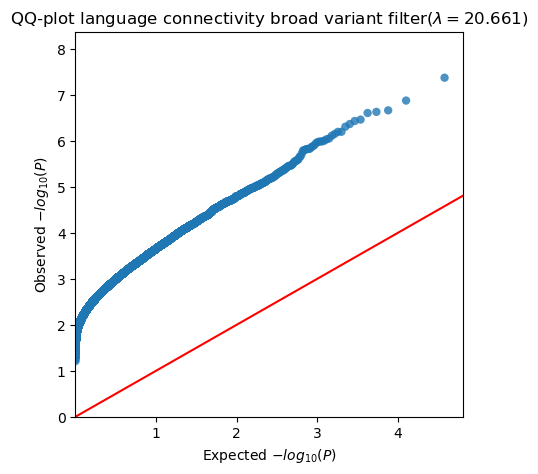

In [55]:
qq_wrap(df = data_skato_broad,
       y_name = "MINP_edges",
       title_name = "QQ-plot language connectivity broad variant filter",
       path_name = os.path.join(results_path, "Figs", "QQ_plot_exome_lang_conn_broad.png"))

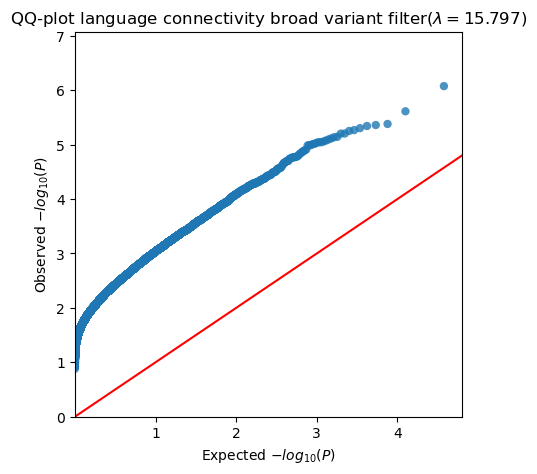

In [56]:
qq_wrap(df = data_skato_broad,
       y_name = "MINP_HDs",
       title_name = "QQ-plot language connectivity broad variant filter",
       path_name = os.path.join(results_path, "Figs", "QQ_plot_exome_HDs_broad.png"))

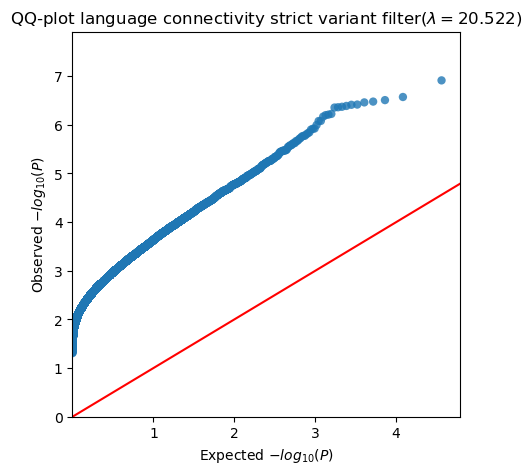

In [57]:
qq_wrap(df = data_skato_strict,
       y_name = "MINP_edges",
       title_name = "QQ-plot language connectivity strict variant filter",
       path_name = os.path.join(results_path, "Figs", "QQ_plot_exome_edges_strict.png"))

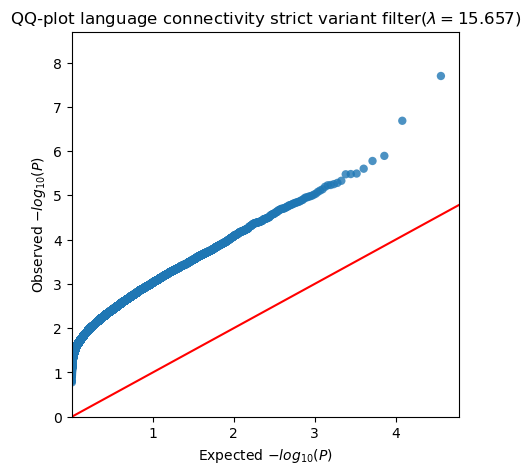

In [58]:
qq_wrap(df = data_skato_strict,
       y_name = "MINP_HDs",
       title_name = "QQ-plot language connectivity strict variant filter",
       path_name = os.path.join(results_path, "Figs", "QQ_plot_exome_HDs_strict.png"))

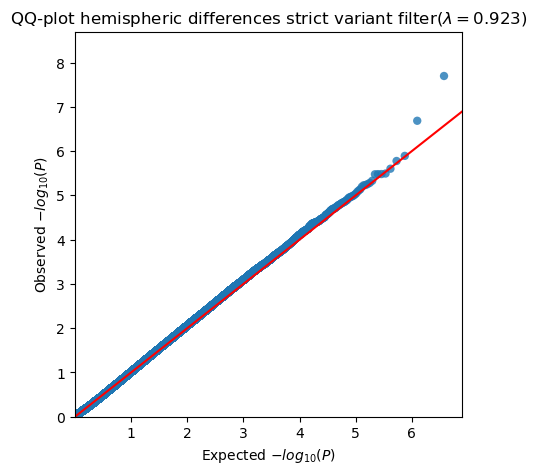

In [72]:

fn_pheno_edges="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt"
fn_pheno_HDs="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt"


qq_wrap2(df = data_skato_strict,
       y_name = "MINP_HDs",
       title_name = "QQ-plot hemispheric differences strict variant filter",
       fn_pheno = fn_pheno_HDs,
       path_name = os.path.join(results_path, "Figs", "QQ_plot_exome_HDs_strict2.png"))

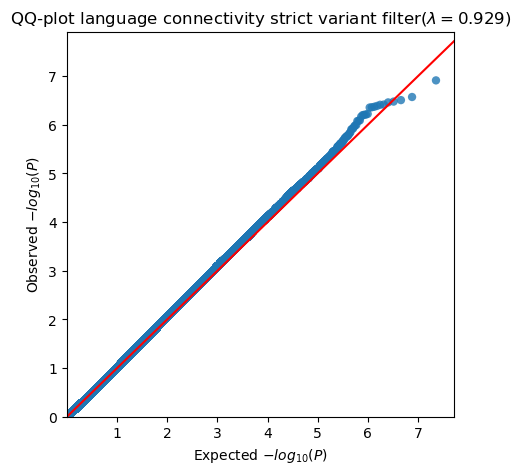

In [68]:
qq_wrap2(df = data_skato_strict,
       y_name = "MINP_edges",
       title_name = "QQ-plot language connectivity strict variant filter",
       fn_pheno = fn_pheno_edges,
       path_name = os.path.join(results_path, "Figs", "QQ_plot_exome_HDs_strict2.png"))

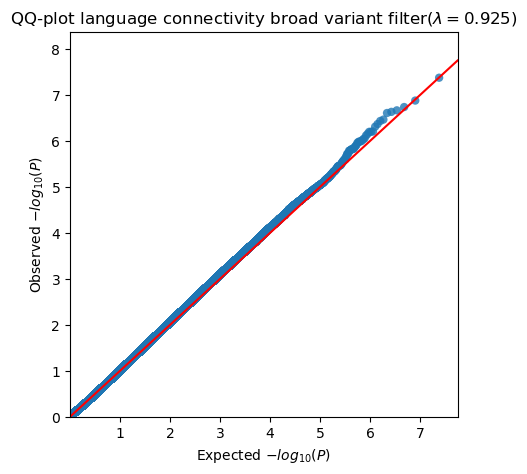

In [70]:
qq_wrap2(df = data_skato_broad,
       y_name = "MINP_edges",
       title_name = "QQ-plot language connectivity broad variant filter",
       fn_pheno = fn_pheno_edges,
       path_name = os.path.join(results_path, "Figs", "QQ_plot_exome_lang_conn_broad2.png"))

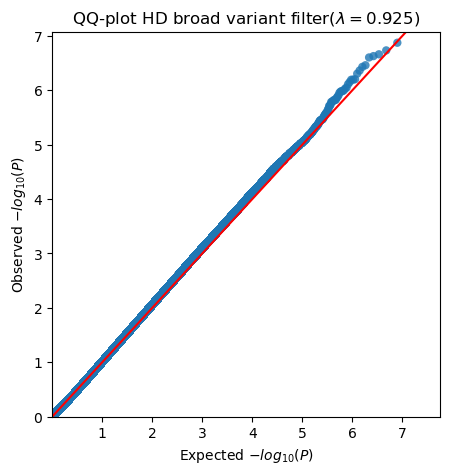

In [74]:
qq_wrap2(df = data_skato_broad,
       y_name = "MINP_HDs",
       title_name = "QQ-plot HD broad variant filter",
       fn_pheno = fn_pheno_edges,
       path_name = os.path.join(results_path, "Figs", "QQ_plot_exome_HD_broad2.png"))

In [104]:
ps_edges.shape

(5, 629)

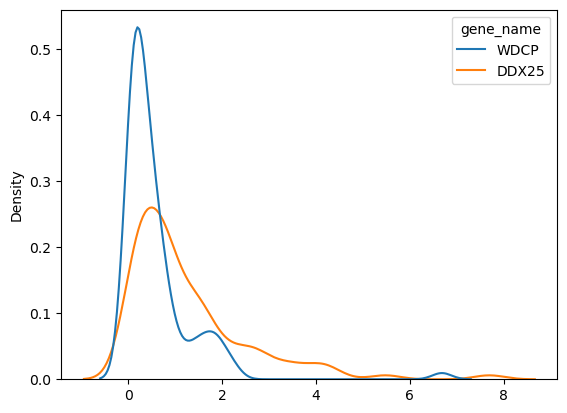

/tmp/ipykernel_31726/3256974931.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumulative_pos'] = pd.concat(cumulative_pos)
/tmp/ipykernel_31726/3256974931.py:165: UserWarning: The palette list has more values (24) than needed (23), which may not be intended.
  g = sns.scatterplot(data=df,
/tmp/ipykernel_31726/3256974931.py:179: UserWarning: The palette list has more values (24) than needed (23), which may not be intended.
  g = sns.scatterplot(data=df,


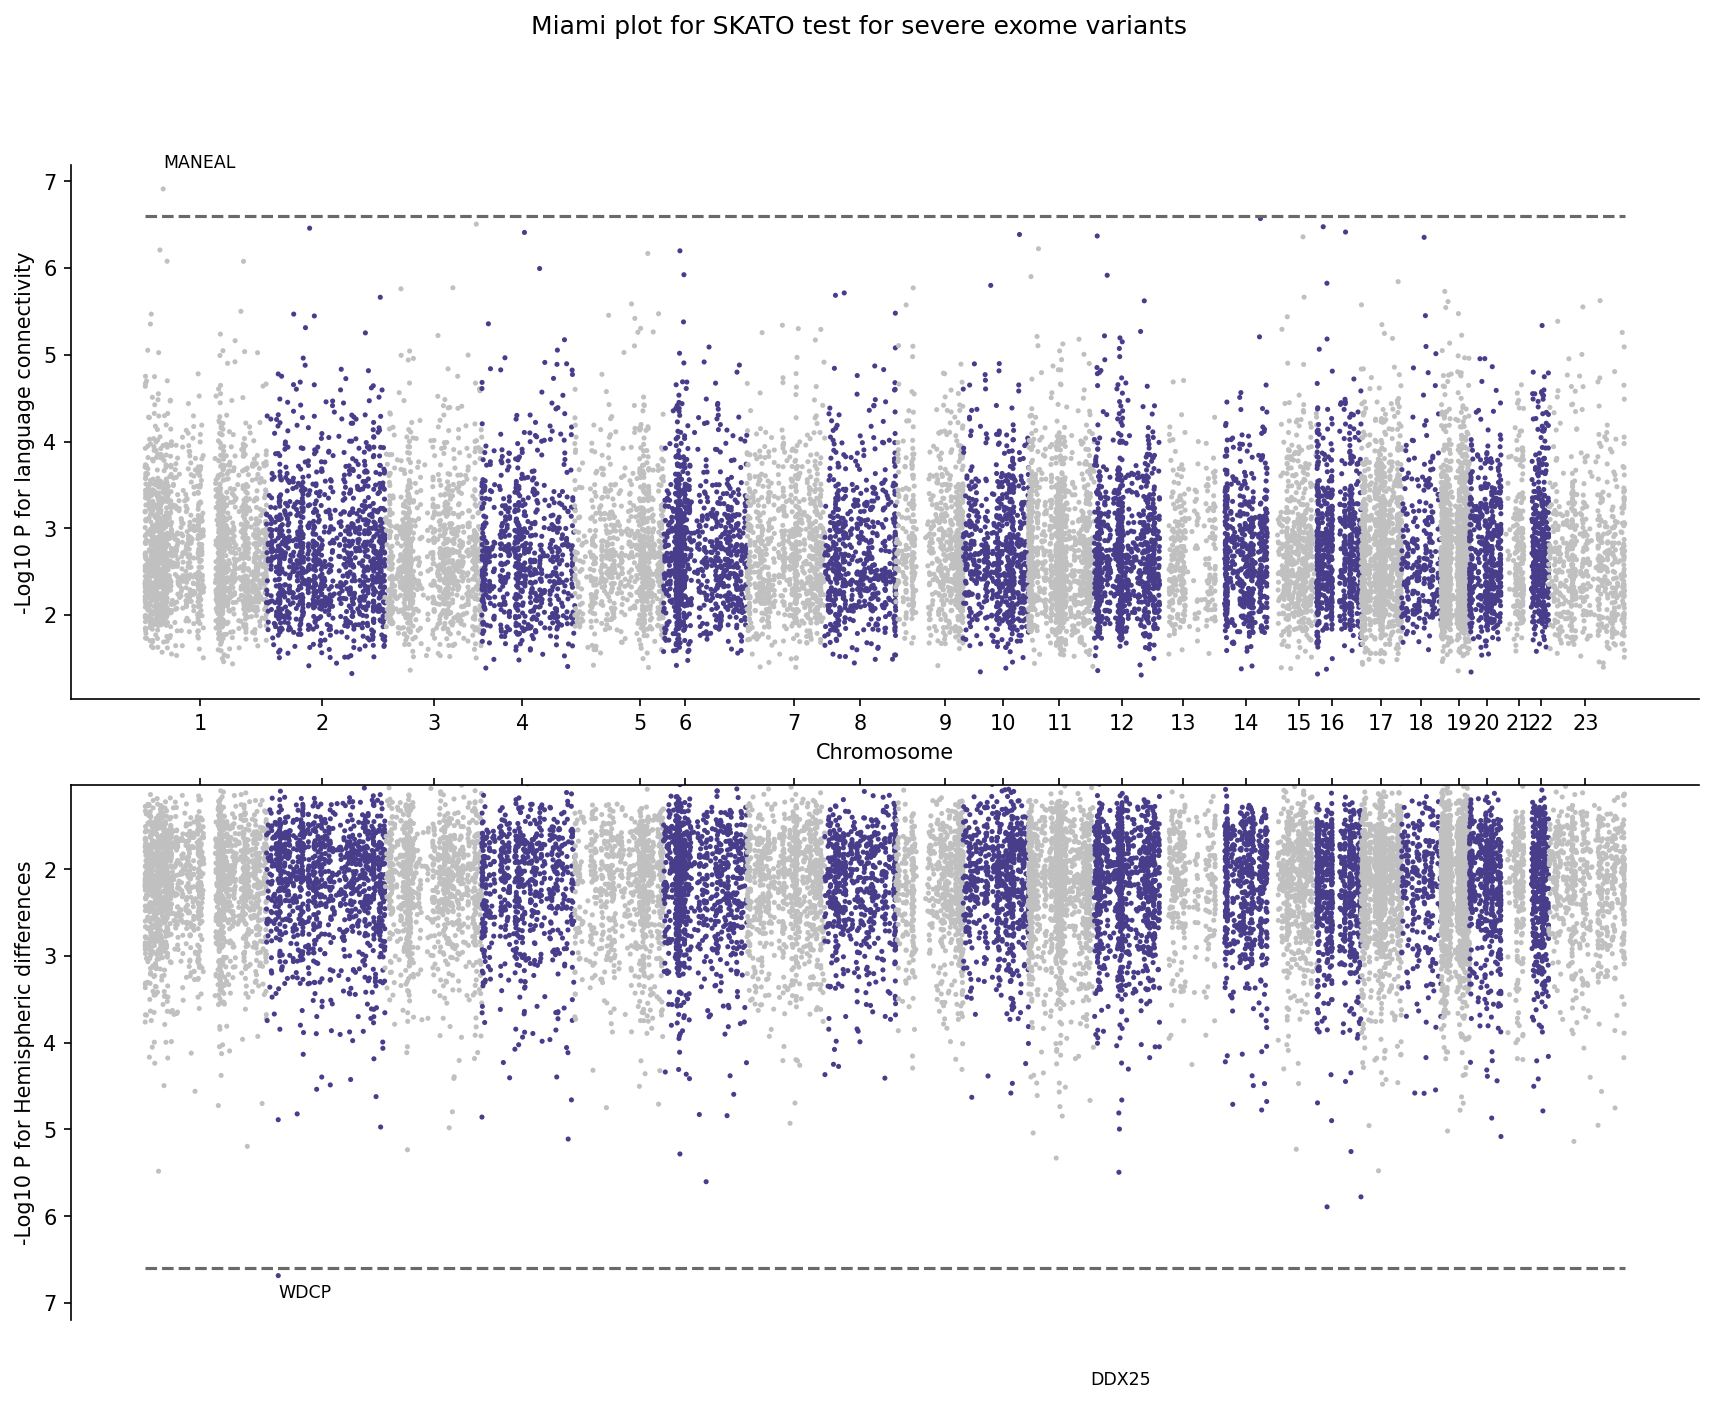

In [26]:
data_skato_strict = data[np.array([data["TEST"] == "ADD-SKATO", data["ALLELE1"] == "Strict.0.01"]).all(0).reshape((len(data), 1))]
miami_exome_regenie(df=data_skato_strict,
                    y_name1 = "MINP_edges",
                    y_name2 = "MINP_HDs",
                    y_dsc1 = "-Log10 P for language connectivity",
                    y_dsc2 = "-Log10 P for Hemispheric differences",
                    title_str = "Miami plot for SKATO test for severe exome variants",
                    no_phenos_1 = edge_phenos,
                    no_phenos_2 = HD_phenos)
plt.savefig(os.path.join(results_path, "Figs", "SKATO_strict_new.png"))

/tmp/ipykernel_31726/3256974931.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumulative_pos'] = pd.concat(cumulative_pos)
/tmp/ipykernel_31726/3256974931.py:165: UserWarning: The palette list has more values (24) than needed (23), which may not be intended.
  g = sns.scatterplot(data=df,
/tmp/ipykernel_31726/3256974931.py:179: UserWarning: The palette list has more values (24) than needed (23), which may not be intended.
  g = sns.scatterplot(data=df,


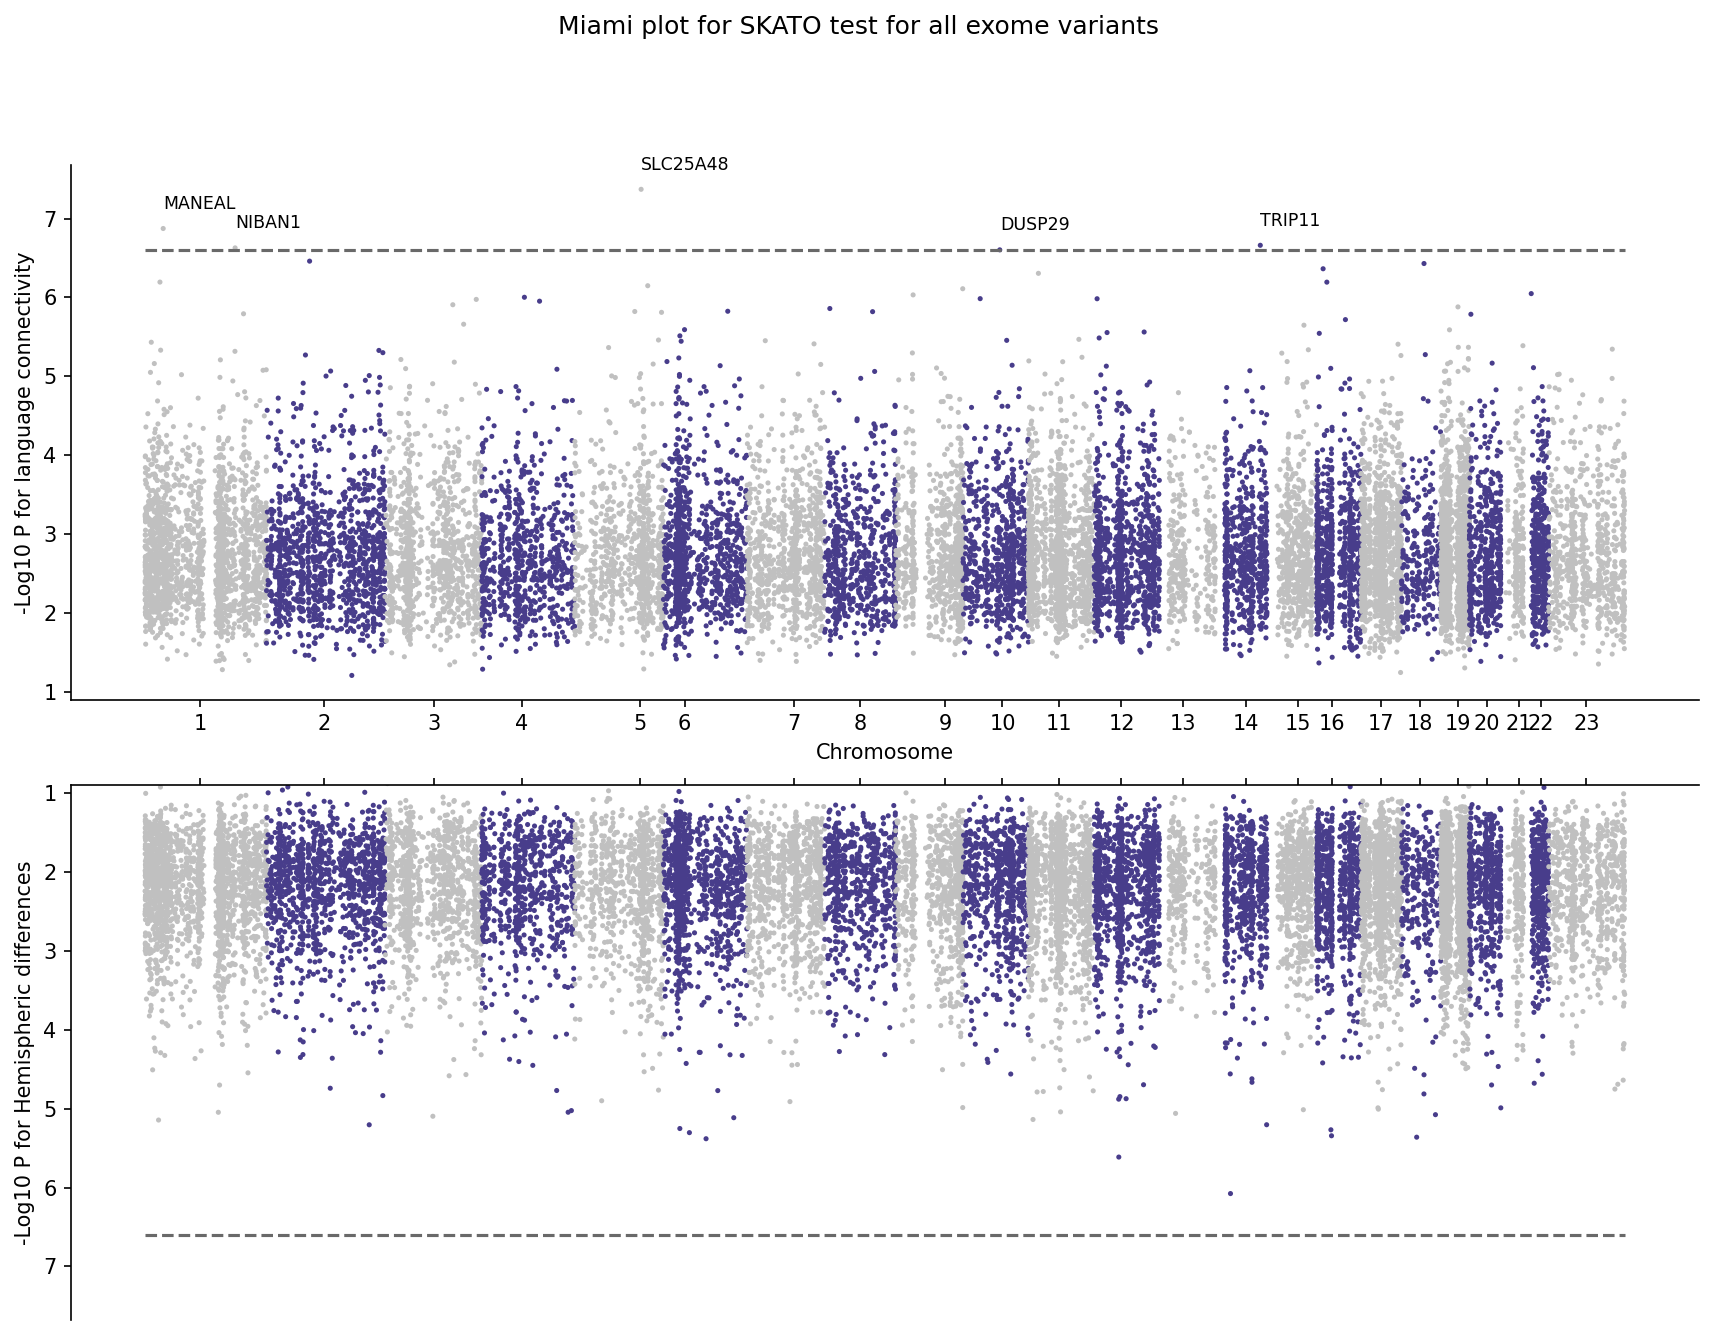

In [27]:
data_skato_broad = data[np.array([data["TEST"] == "ADD-SKATO", data["ALLELE1"] == "Broad.0.01"]).all(0).reshape((len(data), 1))]
miami_exome_regenie(df=data_skato_broad,
                    y_name1 = "MINP_edges",
                    y_name2 = "MINP_HDs",
                    y_dsc1 = "-Log10 P for language connectivity",
                    y_dsc2 = "-Log10 P for Hemispheric differences",
                    title_str = "Miami plot for SKATO test for all exome variants",
                    no_phenos_1 = edge_phenos,
                    no_phenos_2 = HD_phenos)
plt.savefig(os.path.join(results_path, "Figs", "SKATO_broad_new.png"))

In [81]:
from pymare import core, estimators

def get_meta_regression_results(data, betas_names, se_names, col_name, n=29681):
    """
    """
    
    #set up input
    betas = data[betas_names].to_numpy()
    se = data[se_names].to_numpy()
    var = se * np.sqrt(n)
    col_names = ["Meta_P_"+col_name, "Meta_beta_"+col_name, "Meta_se_"+col_name]
    res=np.zeros((len(data), len(col_names)))
    
    #for loop for meta regression
    for i, idx in enumerate(data.index.values):
        dataset = core.Dataset(y=betas[i,:], v=se[i,:], add_intercept=True) #=[29681]*len(betas_from_gene_1),
        est  = estimators.VarianceBasedLikelihoodEstimator(method="REML").fit_dataset(dataset)
        results = est.summary()
        res[i,:] = results.to_df()["p-value estimate se".split()].to_numpy()
        
    data[col_names] = res
    ps = res[:,0]
    data["Meta_LOGP_"+col_name] = -np.log10(ps, out=np.zeros_like(ps), where=(ps != 0) )
    
    return data

fn_pheno_edges="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt"
fn_pheno_HDs="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt"

betas_edges = ["BETA_sent_edges_"+x for x in load_column_names(fn_pheno_edges)]
betas_HDs = ["BETA_sent_edges_"+x for x in load_column_names(fn_pheno_HDs)]
se_edges = ["SE_sent_edges_"+x for x in load_column_names(fn_pheno_edges)]
se_HDs = ["SE_sent_edges_"+x for x in load_column_names(fn_pheno_HDs)]

data_burden_strict = data[np.array([data["TEST"] == "ADD", data["ALLELE1"] == "Strict.0.01"]).all(0).reshape((len(data), 1))]

data_burden_strict = get_meta_regression_results(data_burden_strict, betas_edges, se_edges, "edges")
data_burden_strict = get_meta_regression_results(data_burden_strict, betas_HDs, se_HDs, "HDs")

/tmp/ipykernel_31726/3210566635.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_names] = res
/tmp/ipykernel_31726/3210566635.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_names] = res
/tmp/ipykernel_31726/3210566635.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [17]:
from scipy.stats import combine_pvalues

def get_combined_P_REGENIE(data, method="fisher", pheno_list=None):
    """
    Finds highest -logp value per variant
    
    Returns data with MIN_LOGP column added.
    
    """
    #filter
    if pheno_list is None:
        r=re.compile("LOGP_*.")
        pheno_list = list(filter(r.match, data.columns))
    
    #find highest
    p = np.power(10, -data[pheno_list].to_numpy())
    fisher_p = np.ones(len(data), dtype=np.float64)
    
    for i in range(len(data)):
        _, fisher_p[i] = combine_pvalues(p[i,:], method=method)
        
    return -np.log10(fisher_p, out=np.zeros_like(fisher_p), where=(fisher_p != 0) )
        
fn_pheno_edges="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt"
fn_pheno_HDs="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt"

phenos_edges = ["LOGP_sent_edges_"+x for x in load_column_names(fn_pheno_edges)]
phenos_HDs = ["LOGP_sent_edges_"+x for x in load_column_names(fn_pheno_HDs)]
    
#data["Fisher_P_edges"] = get_combined_P_REGENIE(data, method = "fisher", pheno_list = phenos_edges)
#data["Fisher_P_HDs"] = get_combined_P_REGENIE(data, method="fisher", pheno_list = phenos_HDs)
#data["Stouffer_P_edges"] = get_combined_P_REGENIE(data, method="stouffer", pheno_list = phenos_edges)
#data["Stouffer_P_HDs"] = get_combined_P_REGENIE(data, method="stouffer", pheno_list = phenos_HDs)
#data["Pearson_P_edges"] = get_combined_P_REGENIE(data, method = "pearson", pheno_list = phenos_edges)
#data["Pearson_P_HDs"] = get_combined_P_REGENIE(data, method="pearson", pheno_list = phenos_HDs)
#data["M_G_P_edges"] = get_combined_P_REGENIE(data, method="mudholkar_george", pheno_list = phenos_edges)
#data["M_G_P_HDs"] = get_combined_P_REGENIE(data, method="mudholkar_george", pheno_list = phenos_HDs)

[[0.96246357 0.43455925 0.32329948 ... 0.96940064 0.80402768 0.8263037 ]
 [0.16644663 0.23292065 0.15802034 ... 0.50956783 0.44415545 0.68691658]
 [0.27187545 0.37020902 0.25895065 ... 0.45169991 0.63675007 0.77465441]
 ...
 [0.00382842 0.11272546 0.01758531 ... 0.00137515 0.04118698 0.05989078]
 [0.00443895 0.13018831 0.02203079 ... 0.00153592 0.05354143 0.08070678]
 [0.0486833  0.09308935 0.03279291 ... 0.01746305 0.05037441 0.32803788]]


/home/jitame/bin/anaconda3/envs/results_env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:8635: RuntimeWarning: divide by zero encountered in log1p
  statistic = 2 * np.sum(np.log1p(-pvalues))


[[0.27648845 0.27555545 0.63339991 ... 0.57399353 0.91432691 0.38999496]
 [0.41833481 0.20180039 0.43172083 ... 0.55186138 0.07894779 0.5884953 ]
 [0.50484609 0.32497953 0.62313479 ... 0.71496536 0.13282414 0.61253795]
 ...
 [0.95339792 0.3212107  0.90506923 ... 0.70325528 0.11879879 0.31044595]
 [0.7806134  0.35646673 0.93749077 ... 0.8209377  0.16532975 0.28720368]
 [0.67215742 0.2530329  0.9077549  ... 0.91400043 0.26433581 0.20329889]]
[[0.96246357 0.43455925 0.32329948 ... 0.96940064 0.80402768 0.8263037 ]
 [0.16644663 0.23292065 0.15802034 ... 0.50956783 0.44415545 0.68691658]
 [0.27187545 0.37020902 0.25895065 ... 0.45169991 0.63675007 0.77465441]
 ...
 [0.00382842 0.11272546 0.01758531 ... 0.00137515 0.04118698 0.05989078]
 [0.00443895 0.13018831 0.02203079 ... 0.00153592 0.05354143 0.08070678]
 [0.0486833  0.09308935 0.03279291 ... 0.01746305 0.05037441 0.32803788]]


/home/jitame/bin/anaconda3/envs/results_env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:8639: RuntimeWarning: divide by zero encountered in log1p
  statistic = -np.sum(np.log(pvalues)) + np.sum(np.log1p(-pvalues))


[[0.27648845 0.27555545 0.63339991 ... 0.57399353 0.91432691 0.38999496]
 [0.41833481 0.20180039 0.43172083 ... 0.55186138 0.07894779 0.5884953 ]
 [0.50484609 0.32497953 0.62313479 ... 0.71496536 0.13282414 0.61253795]
 ...
 [0.95339792 0.3212107  0.90506923 ... 0.70325528 0.11879879 0.31044595]
 [0.7806134  0.35646673 0.93749077 ... 0.8209377  0.16532975 0.28720368]
 [0.67215742 0.2530329  0.9077549  ... 0.91400043 0.26433581 0.20329889]]


In [54]:
def save_betas(data, pheno_list, out_fn):
    data = data.set_index("gene_id")
    data[pheno_list].to_csv(out_fn)

In [92]:
def create_zmat_permute(data, pheno, out_fn, permute=True, seed=2023):
    
    beta_pheno = ["BETA_sent_edges_"+x for x in pheno]
    se_pheno = ["SE_sent_edges_"+x for x in pheno]
    betas = data[beta_pheno].to_numpy()
    se = data[se_pheno].to_numpy()
    zmat = np.divide(betas, se)
    print(zmat)
    pd.DataFrame(data=zmat, index=data.index.values, columns=pheno).to_csv(out_fn, index=False)
    
    if permute:
        rng = np.random.default_rng(seed=seed)
        zmat_perm = rng.permutation(zmat, axis=0)
        zmat_perm = rng.permutation(zmat_perm, axis=1)
        pd.DataFrame(data=zmat_perm, index=data.index.values, columns=pheno).to_csv(out_fn[:-4]+"_permuted.csv", index=False)

In [57]:
fn_pheno_edges="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt"
fn_pheno_HDs="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt"

beta_phenos_edges = ["BETA_sent_edges_"+x for x in load_column_names(fn_pheno_edges)]
beta_phenos_HDs = ["BETA_sent_edges_"+x for x in load_column_names(fn_pheno_HDs)]
se_phenos_edges = ["SE_sent_edges_"+x for x in load_column_names(fn_pheno_edges)]
se_phenos_HDs = ["SE_sent_edges_"+x for x in load_column_names(fn_pheno_HDs)]

out_names = ["beta_edges_burden_strict.csv", "beta_HDs_burden_strict.csv", "SE_edges_burden_strict.csv", "SE_HDs_burden_strict.csv"]
pheno_names = [beta_phenos_edges, beta_phenos_HDs, se_phenos_edges, se_phenos_HDs]

for phenos, out_fn in zip(pheno_names, out_names):
    save_betas(data_burden_strict, phenos, os.path.join("/data/clusterfs/lag/users/jitame/SENT_CORE/geno/regenie_gene_based/", out_fn))



In [93]:
fn_pheno_edges="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt"
fn_pheno_HDs="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt"
phenos_edges = load_column_names(fn_pheno_edges)
phenos_HD = load_column_names(fn_pheno_HDs)

create_zmat_permute(data=data_burden_strict,
                    pheno=phenos_edges,
                    out_fn=os.path.join("/data/clusterfs/lag/users/jitame/SENT_CORE/geno/regenie_gene_based/", "zmat_edges_burden_strict.csv"))
create_zmat_permute(data=data_burden_strict,
                    pheno=phenos_HD,
                    out_fn=os.path.join("/data/clusterfs/lag/users/jitame/SENT_CORE/geno/regenie_gene_based/", "zmat_HDs_burden_strict.csv"))

[[ 0.12477284  0.1184384  -0.26374327 ...  1.06794061  0.61494926
   0.53327432]
 [ 0.32545261  1.1162464  -0.09068884 ... -0.49316009 -0.82448075
  -1.01627432]
 [ 0.50089154 -2.1297341  -1.25678026 ...  1.31599339 -0.40552241
   1.86706256]
 ...
 [-1.46349303  0.41298075 -0.10423405 ... -1.28438875 -0.10285159
  -0.21888876]
 [ 0.0368454  -0.41757586 -0.65179864 ...  0.43861123  0.18081481
   0.67741946]
 [ 0.14185744  0.7931279  -0.00788874 ... -1.40068006  1.10146274
   0.22190092]]
[[-0.97769112 -0.02307274  0.40382575 ... -0.64688234  1.31834187
  -0.81045054]
 [ 2.09495887  0.54411251  0.29914368 ... -1.08111673 -0.76896947
   1.00556351]
 [-2.16460191 -0.23396555  0.89313023 ...  0.77053245  1.85492527
   1.08173869]
 ...
 [ 0.56614319 -0.37661425  0.75362862 ... -0.96159438 -0.03715167
  -0.96511222]
 [ 0.36600868  1.15908939  1.14590849 ... -0.49826877 -1.98343948
  -1.25091311]
 [-0.08275165  0.49003085  0.68495198 ... -0.29076983  1.18035187
  -0.37011614]]


In [ ]:
### Comparison with MRP 

In [36]:
def get_chr_no(fn):
    """
    Gets chromosome number from filename
    """
    c = re.search("_c[0-9 X]*_", fn)
    chr_no = c.group()[2:-1]
    if chr_no == "X":
        return int(23)
    else:
        return int(chr_no)

def read_mrp_exome(mrp_file):
    """  
    Reads MRP exome gene-level data, gets chromosome number from file name and returns pandas dataframe
    """
    #load data
    mrp_data = pd.read_csv(mrp_file, sep="\t", compression="gzip", engine="pyarrow")
    
    #add chromosome number
    mrp_data["CHR"] = get_chr_no(mrp_file)
    
    return mrp_data

base_path = "/data/clusterfs/lag/users/jitame/SENT_CORE/geno/mrp/"
reg_base_path=os.path.join(base_path, "c3/mrp_exome_c3_LDSC_vanilla")
data_mrp = read_mrp_exome(os.path.join(reg_base_path, "wb_mrp_exome_c3_LDSC_vanilla_c3_edges_gene_maf_0.01_se_100.0.tsv.gz"))

In [37]:
data_burden = data[np.array([data["TEST"] == "ADD", data["ALLELE1"] == "Strict.0.01"]).all(0).reshape((len(data), 1))]
data_burden.set_index("gene_name", inplace=True)
data_mrp.set_index("gene", inplace=True)
data_all = data_burden.join(data_mrp)
#data_all = data.join(data_mrp, on=gene

In [43]:
data_SKATO = data[np.array([data["TEST"] == "ADD-SKATO", data["ALLELE1"] == "Strict.0.01"]).all(0).reshape((len(data), 1))]
data_SKATO.set_index("gene_name", inplace=True)
data_all2 = data_SKATO.join(data_mrp)

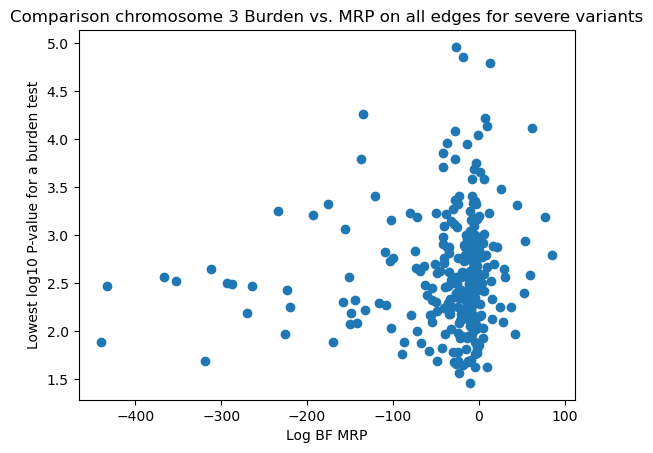

In [45]:
plt.scatter(data_all.log_10_BF_study_similar_var_independent_sigma_m_mpc_pli_ptv.to_numpy(), data_all.MINP_edges.to_numpy())
plt.title("Comparison chromosome 3 Burden vs. MRP on all edges for severe variants")
plt.xlabel("Log BF MRP")
plt.ylabel("Lowest log10 P-value for a burden test")
plt.savefig(os.path.join(results_path, "Figs", "MRP_Burden_chromosome_3.png"))

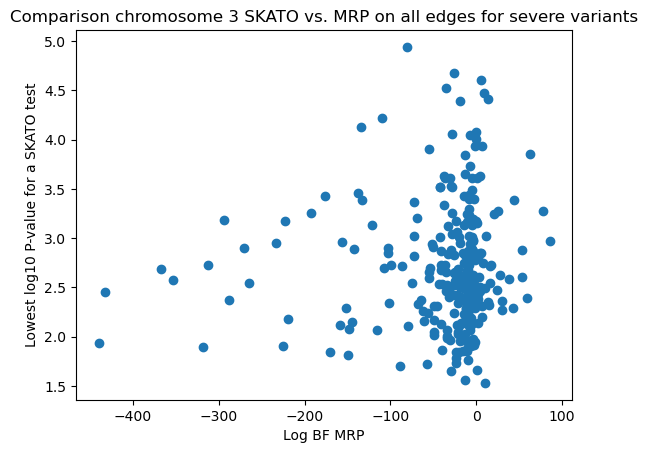

In [47]:
plt.scatter(data_all2.log_10_BF_study_similar_var_independent_sigma_m_mpc_pli_ptv.to_numpy(), data_all2.MINP_edges.to_numpy())
plt.title("Comparison chromosome 3 SKATO vs. MRP on all edges for severe variants")
plt.xlabel("Log BF MRP")
plt.ylabel("Lowest log10 P-value for a SKATO test")
plt.savefig(os.path.join(results_path, "Figs", "MRP_SKATO_chromosome_3.png"))